In [2]:
import cv2
import os
from sklearn.model_selection import train_test_split
import numpy as np
import timeit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from joblib import dump, load
import matplotlib.pyplot as plt
from skimage.transform import resize


## Data Preparation


### Helper functions to transform, save/load data

In [4]:
def save_data(cells, labels):
    """ save cell and label data to disk """
    np.save('data/Cells', cells, allow_pickle=False)
    np.save('data/Labels', labels, allow_pickle=False)
    
def load_data():
    """ load cell and label data from disk """
    cells = np.load('data/Cells.npy')
    labels = np.load('data/Labels.npy')
    return cells, labels

def save_model(model):
    """ pickel model to disk """
    dump(model, 'svm_model_HOG.joblib')
    

### Functions to transform, resize, inspect and save data


#### Convert images to grayscale, and resize to 50x50 

In [39]:
def transform_images(grayscale=True):
    """ convert color images to grayscale, resize"""
    infected = (image for image in os.listdir('Parasitized'))
    uninfected = (image for image in os.listdir('Uninfected'))
    data = []
    labels = []
    for idx, img in enumerate(infected):
        if grayscale:
            image = cv2.imread('./Parasitized/' + img, cv2.IMREAD_GRAYSCALE)
        else:
            image = cv2.imread('./Parasitized/' + img)
        resize_img = resize(image, (50,50))
        data.append(resize_img)
        labels.append(1)

    for idx, img in enumerate(uninfected):
        if grayscale:
            image = cv2.imread('./Uninfected/' + img, cv2.IMREAD_GRAYSCALE)
        else:
            image = cv2.imread('./Uninfected/' + img)
        resize_img = resize(image, (50,50))
        data.append(resize_img)
        labels.append(0)
    
    cells = np.array(data).astype('float32')
    labels = np.array(labels).astype('int32')
    
    return cells, labels


#### inspect images

In [32]:
def inspect_images(cells, labels):
    plt.figure(1, figsize=(5,5))
    for i in range(25):
        random_image = np.random.randint(0, cells.shape[0], 1)
        plt.subplot(5, 5, i+1)
        plt.subplots_adjust(hspace=0.5, wspace=0.5)
        plt.imshow(cells[random_image][0], cmap='gray')
        plt.title('{}'.format('Infected' if labels[random_image[0]] == 1 else 'Unifected'))
        plt.xticks([]), plt.yticks([])
    plt.show()
    

#### call functions to transform images to grayscale, resize, and save to disk

In [40]:
cells, labels = transform_images()

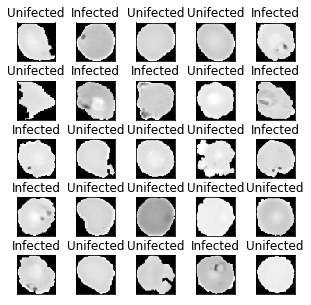

In [41]:
inspect_images(cells,labels)

In [49]:
save_data(cells,labels)


#### run this block if loading cell and label data from previous run

In [5]:
cells, labels = load_data()


## Feature Engineering: Create histogram of grayscale intensity vectors
+ darker spots in the images are indicative of malaria; use this as a feature to classify images
+ chose the number of buckets per guidance from this article: https://www.learnopencv.com/histogram-of-oriented-gradients/

In [6]:
def create_histogram_vectors(grayscale_data):
    """ create 10 bins of gradients """
    hist = np.zeros((grayscale_data.shape[0],9))  # initialize 2dim array of nrow(grayscale_image) x 9
    for  idx, image_data in enumerate(grayscale_data):
        counts, bins = np.histogram(image_data, bins=9, range=(0.1,1))  # range excludes 0.0--black gradient
        hist[idx] = counts / np.sum(counts)  # normalize the gradients by the sum of all the gradients to get a value between 0 - 1
    hist = hist.astype('float32')
    return hist


#### Create histogram of gradient feature set from grayscale ndarray

In [7]:
hist_features = create_histogram_vectors(cells)


#### Create train and test data

In [8]:
train_x, test_x, train_y, test_y = train_test_split(hist_features, labels, train_size=0.7, test_size=0.3)


## Conduct PCA for feature selection of uncorrelated predictors
+ find the optimum number of principal components/features
+ plot shows that 7 - 8 components explain almost all the variance of the dataset, let's choose 7

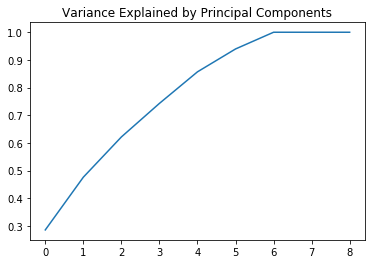

In [9]:
pre_process = StandardScaler()
pre_process.fit(train_x)
train_x_stand = pre_process.transform(train_x)

pca = PCA()
pca.fit(train_x_stand)
fig, ax = plt.subplots()  # plot just one subplot
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_title('Variance Explained by Principal Components')
plt.show()


## Build pipeline to gridsearch SVM parameters
+ 
+ gridsearch over the 'C'; higher C attempts classify more data points
+ gridsearch over 'gamma'; higher gamma maximizes the hyperplane margin/distance between classes
+ gridsearch with 3 cross-validated folds
+ run PCA during each iteration to choose the best features


In [15]:
def grid_search():
    standardized_data = StandardScaler()
    pca = PCA(n_components=7)
    svc = SVC()
    pipe = Pipeline([('standardized_data', standardized_data),
                     ('pca', pca),
                     ('svc', svc)])
    
    start = timeit.default_timer()
    svm_parameters = [{'svc__C':[0.1,1.,10.,100.], 'svc__kernel':['rbf'], 'svc__gamma':[0.1,1.,10.,100.]}]  
    grid_search_svm = GridSearchCV(pipe, svm_parameters, cv=3, n_jobs=-1)
    grid_search_svm.fit(train_x, train_y)
    print(f'Runtime for SVM:{timeit.default_timer() - start}')
    return grid_search_svm


#### print best performing model

In [16]:
svm_model = grid_search()
svm_model.best_params_


Runtime for SVM:195.73325997800004


{'svc__C': 100.0, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

### SVM performance metrics
+ https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

In [17]:
svm_results = svm_model.predict(test_x)

In [18]:
confusion_matrix(test_y, svm_results)

array([[3575,  606],
       [ 770, 3317]])

In [19]:
print(f"Accuracy: {accuracy_score(test_y, svm_results)}")
print(f"Recall: {recall_score(test_y, svm_results)}")
print(classification_report(test_y, svm_results))


Accuracy: 0.8335752298016449
Recall: 0.8115977489601175
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      4181
           1       0.85      0.81      0.83      4087

   micro avg       0.83      0.83      0.83      8268
   macro avg       0.83      0.83      0.83      8268
weighted avg       0.83      0.83      0.83      8268



#### Pickle model to disk

In [20]:
save_model(svm_model)

dict_keys(['C', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])